In [25]:
import numpy as np 
import scipy as sp 
import pandas as pd 
import quandl
import matplotlib.pyplot as plt
%matplotlib inline 
from matplotlib import style
style.use('ggplot')
from datetime import datetime
from pandas import Series
from sklearn.model_selection import TimeSeriesSplit
from matplotlib import pyplot
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

# Load the Data

I have previously created a complete dataset containing closing prices for all 500 stocks within the S&P500.

Since not all stocks have been live during the whole time period I pulled, some rows will have N/A's. We will drop the columns with N/A's in order to have a complete dataframe

In [26]:
df = pd.read_csv('sp500_joined_closes.csv')
tickers = df.columns.values.tolist()
df.dropna(1, inplace = True)
df['Day_N'] = df['Date'].index
dates = df.Date

In [27]:
df.drop('Date',inplace=True,axis=1)

Need to change [Date] Field from string to Integer in order to include it as a variable

In [114]:
ticker = 'MMM'

In [29]:
start_date = '2000-01-01' #str(input('When would you like to start your training data? '))
end_date = '2016-12-30' #str(input('When would you like it to end? '))

In [30]:
days = 7 #input('How many days into the future would you like to look? ')

In [31]:
ticker_price = df[ticker].copy()

df['30ma'] = ticker_price.rolling(window=30).mean()
df['20ma'] = ticker_price.rolling(window=20).mean()
df['10ma'] = ticker_price.rolling(window=10).mean()
df = df[30:]

Because we include a 30 day rolling price average the oldest 30 days won't have data in that field so we'll need to cut out that data

### By shifting y (the target) by the number of days into the future we'd like to look, we can train our model to predict the future stock price given our current data.

We see that Weekend Data is not given since the markets are not open on the weekends

In [32]:
y = df[ticker]
y_shifted = df[ticker].shift(-days)[:-days]
y = df[ticker][:-days]
X = df[:-days]

We can store the last n days worth of data in order to predict the prices that we cannot "technically" test against since these will be looking beyond our test set

In [33]:
X_for_future = df[-days:]

In [34]:
compare = pd.DataFrame(index= pd.to_datetime(dates.values[30:-days]))
compare['current'] = y.values
compare['{} days into future'.format(days)] = y_shifted.values
compare.tail(10)

,current,7 days into future
2016-12-07,173.870311,175.252978
2016-12-08,173.702416,175.954187
2016-12-09,176.280101,176.438120
2016-12-12,177.415863,176.220844
2016-12-13,176.615892,176.981311
2016-12-14,174.413502,176.536882
2016-12-15,173.840683,176.704778
2016-12-16,175.252978,175.875178
2016-12-19,175.954187,176.201092
2016-12-20,176.438120,176.359111


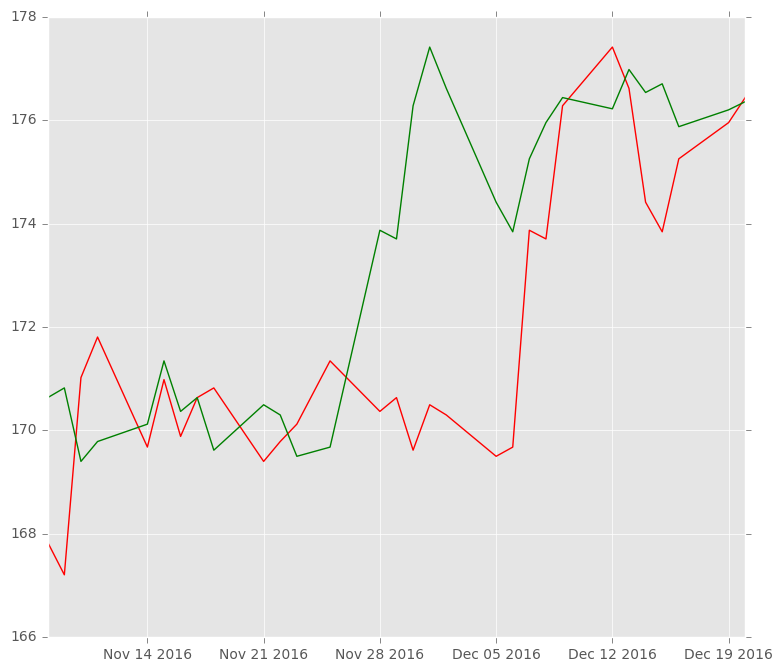

In [35]:
pyplot.figure(1,figsize=(9, 8))
pyplot.plot(compare.current.tail(30),'r')
pyplot.plot(compare['{} days into future'.format(days)].tail(30),'g')
pyplot.show()

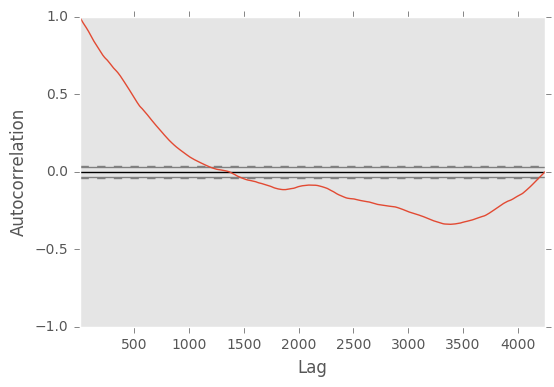

In [36]:
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(df[ticker])

From the Autocorrelation Graph above, we see that the future price of our selected stock is highly correlated with its past stock price but in a decreasing manner.
ie. the more time into the past we look, the less correlated the prices become. 

Therefore, if we want to look farther into the future, we can rely less on our stock price for information and thus will need to add other features
to our model

### Let's set our testing size to the lat 15% of our data

In [37]:
test_size = int(len(X)*.15)
test_size

636

In [38]:
dates.iloc[-636]

'2014-06-25'

### Because we have TimeSeries Data, we will select the last 15% of our data as our testing set and use the first 85% to train our model

In [39]:
X_train = X[:-test_size]
X_test = X[-test_size:]
y_train = y_shifted[:-test_size]
y_test = y_shifted[-test_size:]

In [40]:
print 'Training size of X: ', len(X_train)
print 'Testing size of X: ',len(X_test)
print 'Training size of y: ',len(y_train)
print 'Testing size of y: ',len(y_test)

Training size of X:  3604
Testing size of X:  636
Training size of y:  3604
Testing size of y:  636


### Because we have TimeSeries Data, we need to use a rolling forward Cross Validation Approach on the Training Data for Parameter Selection

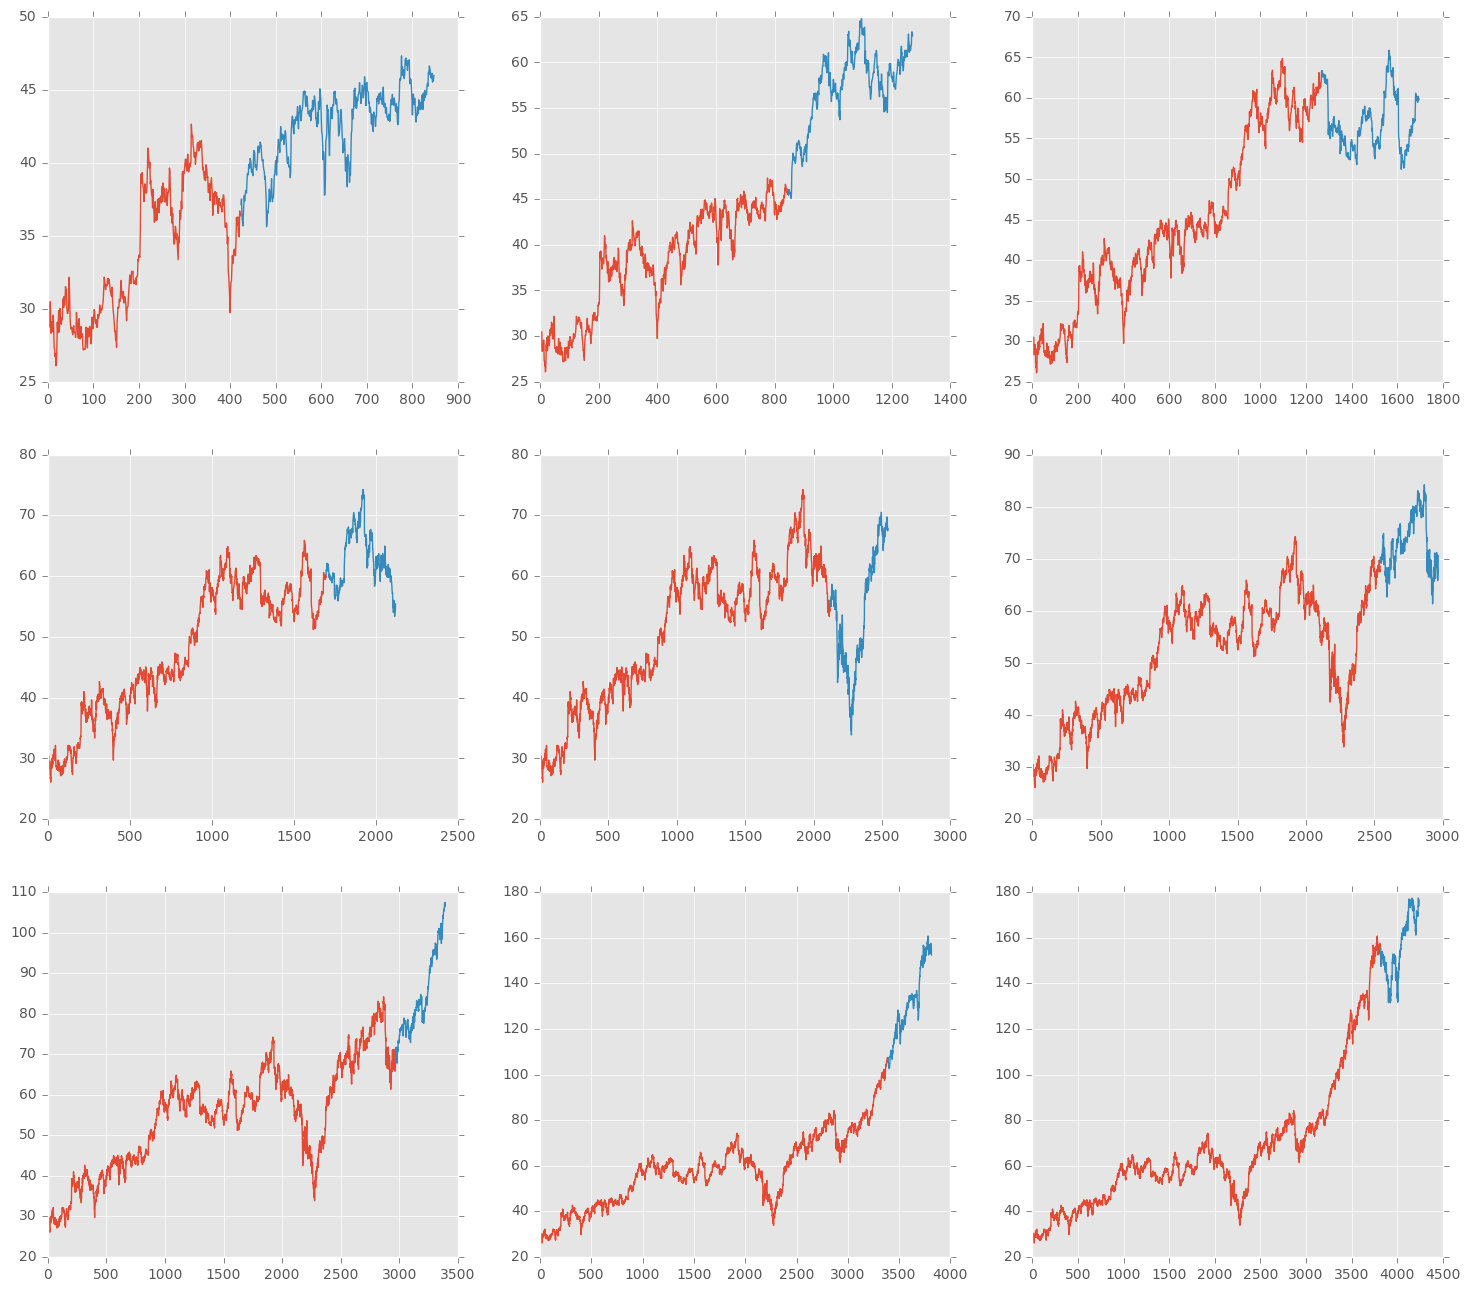

In [41]:
X_for_graph = X[ticker].values
splits = TimeSeriesSplit(n_splits=9)
pyplot.figure(1,figsize=(18, 16))
index = 1
for train_index, test_index in splits.split(X_for_graph):
    train = X_for_graph[train_index]
    test = X_for_graph[test_index]
    #print('Observations: %d' % (len(train) + len(test)))
    #print('Training Observations: %d' % (len(train)))
    #print('Testing Observations: %d' % (len(test)))
    pyplot.subplot(330 + index)
    pyplot.plot(train)
    pyplot.plot([None for i in train] + [x for x in test])
    index += 1
pyplot.show()

# Feature Selection

# PCA

Using PCA we can see the optimal number of feature sets from the full set of stocks.

Below, we see that 1 Principle Component already can explain 88% of our variance and adding each additional Component increases this percentage.

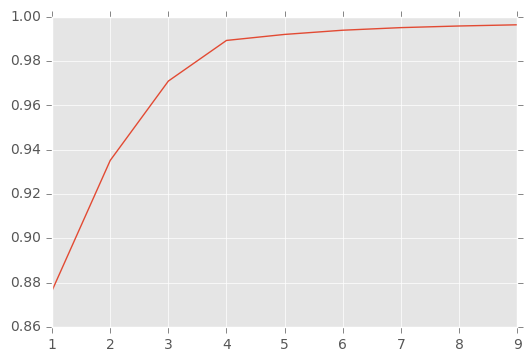

In [44]:
components = range(1,10)
scores = []
# feature extraction
for n in components:
    pca = PCA(n_components=n)
    fit = pca.fit(X_train)
    # summarize components
    #print("Explained Variance: %s") % fit.explained_variance_ratio_
    scores.append(sum(fit.explained_variance_ratio_))
pyplot.plot(range(1,len(scores)+1),scores)
pyplot.show()

We can calculate the additional explained variance from adding another component. Then when this additional amount passes below a threshold, we can select the best number of Principle Components to choose.

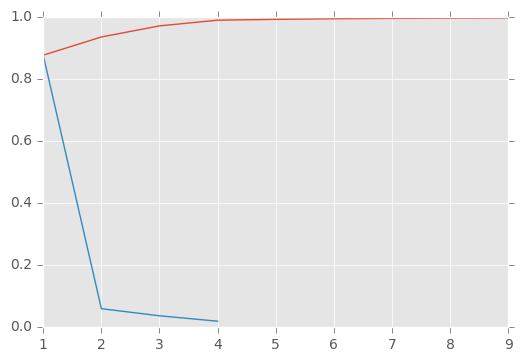

The number of components chosen =  4


In [45]:
values = [scores[0]]
for i in range(1,len(scores)):
    additional_value = (scores[i]-scores[i-1])
    if additional_value <.01:
        n_components = i
        break
    values.append(additional_value)
    
pyplot.plot(range(1,10),scores)
pyplot.plot(range(1,len(values)+1),values)
pyplot.show()
print "The number of components chosen = ", n_components

Based upon the stragety above, I will be choosing 4 components to reshape the data to.

This is an automated stragety that can select the optimal number for any stock and doesn't require user input.

In [46]:
pca = PCA(n_components = n_components)
fit = pca.fit(X_train)
X_train_pca = pd.DataFrame(fit.transform(X_train))
X_test_pca = pd.DataFrame(fit.transform(X_test))
X_for_future_pca = pd.DataFrame(fit.transform(X_for_future))

# Recursive Feature Elimination

In the below code, we are using a Linear Regression to rank the variables. The process starts by using all of the features, then recursively eliminating the worst features untill it has selected a smaller set of features that performed the best.

In [47]:
def feature_ranking(X,y):
    names = list(X.columns)
    #use linear regression as the model
    lr = LinearRegression()
    cv_sets = TimeSeriesSplit(n_splits = 10)
    #scaler = StandardScaler()
    #rank all features, i.e continue the elimination until the last one
    rfecv = RFECV(lr, cv = cv_sets, n_jobs = -1)
    rfecv.fit(X,y)
     
    feature_ranks = sorted(zip(map(lambda x: round(x, 4), rfecv.ranking_), names))
    feature_ranks_df = pd.DataFrame(feature_ranks)
    top_features = list(feature_ranks_df[feature_ranks_df[0]==1][1])
    return top_features

In [48]:
top_features = feature_ranking(X_train,y_train)

In [49]:
top_features

['10ma',
 '20ma',
 '30ma',
 'ADP',
 'AIV',
 'APH',
 'BLL',
 'D',
 'DHR',
 'DLTR',
 'FTR',
 'KEY',
 'LEG',
 'LUV',
 'MMM',
 'MNST',
 'PAYX',
 'PBCT',
 'PLD',
 'RAI',
 'RF',
 'SRE',
 'TSN',
 'VTR',
 'WEC']

In [50]:
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]
X_for_future_top = X_for_future[top_features]

# Building our Models

After performing research on Sklearn's model selection cheat sheet, I have selected the following models as part of my overall process:
### 1. Random Forest Regression
### 2. Stochastic Gradient Decent Regression
### 3. LASSO Regression

Below is the general process by which each model will be trained.

First it will use the TimeSeriesSplit method for Cross Validation. Then the regression algorithm will be defined along with parameters relevant to its optimization. Finally all these will be placed into a Grid Search function in order optimize across the parameters. The best estimator will be returned.

In [51]:
def DTR_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv_sets = TimeSeriesSplit(n_splits = 10)
    cv_sets.split(X,y)

    # Create a decision tree regressor object
    regressor = DecisionTreeRegressor()

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 100
    params = {'max_features':['auto']}

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    #scoring_fnc = make_scorer(performance_metric)

    # Create the grid search object
    grid = GridSearchCV(regressor, params, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

In [140]:
dtr_model = DTR_model(X_train,y_train)
predictions_dtr = dtr_model.predict(X_test)
dtr_score = dtr_model.score(X_test,y_test)

dtr_model_pca = DTR_model(X_train_pca,y_train)
predictions_dtr_pca = dtr_model_pca.predict(X_test_pca)
dtr_pca_score = dtr_model_pca.score(X_test_pca,y_test)

dtr_model_top = DTR_model(X_train_top,y_train)
predictions_dtr_top = dtr_model_top.predict(X_test_top)
dtr_top_score = dtr_model_top.score(X_test_top,y_test)

print 'Without Feature Selection the DTR achieved a score of:' , dtr_score
print 'With the PCA the DTR achieved a score of:', dtr_pca_score
print 'Using the Top Features the DTR achieved a score of:', dtr_top_score

Without Feature Selection the DTR achieved a score of: -3.35576982993
With the PCA the DTR achieved a score of: -2.30698779103
Using the Top Features the DTR achieved a score of: -2.30175013577


In [57]:
def KNR_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv_sets = TimeSeriesSplit(n_splits = 10)
    cv_sets.split(X,y)

    # Create a decision tree regressor object
    regressor = KNeighborsRegressor()

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 100
    params = {'n_neighbors':range(1,3)}

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    #scoring_fnc = make_scorer(performance_metric)

    # Create the grid search object
    grid = GridSearchCV(regressor, params, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

In [58]:
knr_model = KNR_model(X_train,y_train)
predictions_knr = knr_model.predict(X_test)
knr_score = knr_model.score(X_test,y_test)

knr_model_pca = KNR_model(X_train_pca,y_train)
predictions_knr_pca = knr_model_pca.predict(X_test_pca)
knr_pca_score = knr_model_pca.score(X_test_pca,y_test)

knr_model_top = KNR_model(X_train_top,y_train)
predictions_knr_top = knr_model_top.predict(X_test_top)
knr_top_score = knr_model_top.score(X_test_top,y_test)

print 'Without Feature Selection the DTR achieved a score of:' , knr_score
print 'With the PCA the DTR achieved a score of:', knr_pca_score
print 'Using the Top Features the DTR achieved a score of:', knr_top_score

Without Feature Selection the DTR achieved a score of: -2.04320323299
With the PCA the DTR achieved a score of: -1.82356175819
Using the Top Features the DTR achieved a score of: -1.96266194478


In [54]:
knr_model_top.predict(X_for_future_top)

array([ 133.45591953,  133.45591953,  133.45591953,  133.45591953,
        133.45591953,  133.45591953,  133.45591953])

In [111]:
def RFR_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv_sets = TimeSeriesSplit(n_splits = 10)
    cv_sets.split(X,y)

    # Create a decision tree regressor object
    regressor = RandomForestRegressor(n_estimators = 20)

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 100
    params = {'min_samples_leaf':range(1,10)}

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    #scoring_fnc = make_scorer(performance_metric)

    # Create the grid search object
    grid = GridSearchCV(regressor, params, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

In [112]:
#X_train_few2 = X_train[nms]
#X_test_few2 = X_test[nms]
rfr_model = RFR_model(X_train_top,y_train)
predictions_rfr = rfr_model.predict(X_test_top)
rfr_score = rfr_model.score(X_test_top,y_test)

print 'The RFR achieved a score of:' , rfr_score

The RFR achieved a score of: -2.11314132671


In [113]:
rfr_model = RFR_model(X_train,y_train)
predictions_rfr = rfr_model.predict(X_test)
rfr_score = rfr_model.score(X_test,y_test)

rfr_model_pca = RFR_model(X_train_pca,y_train)
predictions_rfr_pca = rfr_model_pca.predict(X_test_pca)
rfr_pca_score = rfr_model_pca.score(X_test_pca,y_test)

rfr_model_top = RFR_model(X_train_top,y_train)
predictions_rfr_top = rfr_model_top.predict(X_test_top)
rfr_top_score = rfr_model_top.score(X_test_top,y_test)

print 'Without Feature Selection the RFR achieved a score of:' , rfr_score
print 'With the PCA the RFR achieved a score of:', rfr_pca_score
print 'Using the Top Features the RFR achieved a score of:', rfr_top_score

Without Feature Selection the RFR achieved a score of: -3.25602614336
With the PCA the RFR achieved a score of: -2.1044904939
Using the Top Features the RFR achieved a score of: -2.21200654966


In [248]:
reg = RandomForestRegressor()
reg.fit(X_train,y_train)
reg.score(X_test,y_test)

-5.3864489632905865

In [252]:
reg.decision_path(X_train)

(<3606x44296 sparse matrix of type '<type 'numpy.int64'>'
 	with 503396 stored elements in Compressed Sparse Row format>,
 array([    0,  4399,  8830, 13277, 17678, 22113, 26540, 30971, 35440,
        39871, 44296]))

In [102]:
def SGD_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
   
    np.random.RandomState
    scaler = StandardScaler()
    #names = X_names
    
    # Create cross-validation sets from the training data
    cv_sets = TimeSeriesSplit(n_splits = 10)
    cv_sets.split(X,y)

    # Create a decision tree regressor object
    regressor = linear_model.SGDRegressor(n_iter=100)

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 100
    params = {'loss':['squared_loss','huber'],'penalty':['none','l2','l1'],'alpha':[.0001,.001,.01,.1],'l1_ratio':[.15,.30,.5,.65]}

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    #scoring_fnc = make_scorer(performance_metric)

    # Create the grid search object
    grid = GridSearchCV(regressor, params, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

In [94]:
nms = ['AAPL','DLTR','LOW','DE','WDC']
nms2 = ['AAPL','RAI','NKE','CB','HRL','KIM','LEG']
X_train_few2 = X_train[nms]
X_test_few2 = X_test[nms]
X_train_few3 = X_train[nms2]
X_test_few3 = X_test[nms2]

In [103]:
sgd2_model = SGD_model(X_train_top,y_train)
predictions_sgd2 = sgd2_model.predict(X_test_top)
sgd2_score = sgd2_model.score(X_test_top,y_test)

In [104]:
sgd2_score

0.90056513637126123

In [105]:
sgd2_model.predict(X_for_future_top)

array([ 178.40653478,  179.10463313,  178.66994104,  178.83736498,
        178.01851251,  178.35588697,  178.50645381])

In [ ]:
X_for_future_few2 = X_for_future[nms]
sgd_model.predict(X_for_future_few2)

In [207]:
sgd3_model = SGD_model(X_train_few3,y_train)
predictions_sgd3 = sgd3_model.predict(X_test_few3)
sgd3_score = sgd3_model.score(X_test_few3,y_test)

In [126]:
sgd_score

0.84244745152808664

In [208]:
sgd_model = SGD_model(X_train_few,y_train)
predictions_sgd = sgd_model.predict(X_test_few)
sgd_score = sgd_model.score(X_test_few,y_test)

In [123]:
sgd_score

0.80109922898183705

In [72]:
clf.score(X_test,y_test)

-8.5519561479175761e+27

1 features gave score of: 0.849210506193
6 features gave score of: 0.83656371524
11 features gave score of: 0.843648738254
16 features gave score of: 0.828798199732
21 features gave score of: 0.844542458284
26 features gave score of: 0.843413904634


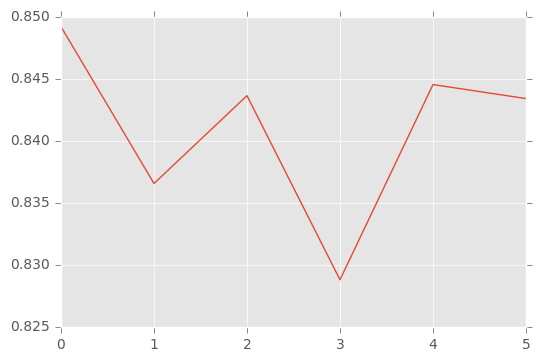

In [60]:
lasso_scores = []
for n_n in range(1,30,5):
    
    names = list(X_train.columns)
    #use linear regression as the model
    lr = LinearRegression()
    #rank all features, i.e continue the elimination until the last one
    rfe = RFE(lr, n_features_to_select=1)
    rfe.fit(X_train,y_train)
    
    X_train_top = sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), names))[:n_n]
    X_names = []
    for i in range(n_n):
        X_names = X_names+[X_train_top[i][1]]
    
    
    scaler = StandardScaler()
    names = X_names
    X_train_few = X_train[names]
    X_test_few = X_test[names]
  
    lasso = Lasso(alpha=.3)
    lasso.fit(X_train_few, y_train)
    score = lasso.score(X_test_few,y_test)
    lasso_scores.append(score)
    print n_n,"features gave score of:", score

pyplot.plot(lasso_scores)
pyplot.show()

In [84]:
def feature_ranking(X,y):
    scores = []
    for i in range(1,11):
        names = list(X.columns)
        #use linear regression as the model
        lr = LinearRegression()
        #scaler = StandardScaler()
        #rank all features, i.e continue the elimination until the last one
        rfe = RFE(lr, n_features_to_select=i)
        rfe.fit(X,y)
        x = round(rfe.score(X,y),4)
        scores.append(x)
        #feature_ranks = sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), names))
        #feature_scores = sorted(rfe.support_), names
    print scores
    #return feature_ranks , feature_scores

In [85]:
feature_ranking(X_train,y_train)

[0.991, 0.991, 0.9911, 0.9913, 0.9914, 0.9914, 0.9914, 0.9914, 0.9917, 0.9918]


In [123]:
names = list(X_train.columns)
#use linear regression as the model
lr = LinearRegression()
cv_sets = TimeSeriesSplit(n_splits = 10)
#scaler = StandardScaler()
#rank all features, i.e continue the elimination until the last one
rfecv = RFECV(lr, cv = cv_sets, n_jobs = -1)
rfecv.fit(X_train,y_train)
rfecv.get_params()

{'cv': TimeSeriesSplit(n_splits=10),
 'estimator': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
 'estimator__copy_X': True,
 'estimator__fit_intercept': True,
 'estimator__n_jobs': 1,
 'estimator__normalize': False,
 'n_jobs': -1,
 'scoring': None,
 'step': 1,
 'verbose': 0}

In [125]:
rfecv.score(X_train,y_train)

0.99311261441448495

In [129]:
len(X_train.columns)

393

## Based on this analysis, I will be using 4 features in my selection

In [59]:
n = 3
names = list(X_train.columns)
#use linear regression as the model
lr = LinearRegression()
#scaler = StandardScaler()
#rank all features, i.e continue the elimination until the last one
rfe = RFE(lr, n_features_to_select=1)
rfe.fit(X_train,y_train)
 
    
X_train_top = sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), names))[:n]
X_names = ['Day_N']
for i in range(n):
    X_names = X_names+[X_train_top[i][1]]
    
names = X_names
X_train_few = X_train[names]
X_test_few  = X_test[names]
  
lasso = Lasso(alpha=.3)
lasso.fit(X_train_few, y_train)

def pretty_print_linear(coefs, names = None, sort = False):
    if names == None:
        names = ["X%s" % x for x in range(len(coefs))]
    lst = zip(coefs, names)
    if sort:
        lst = sorted(lst, key = lambda x:-np.abs(x[0]))
    return " + ".join("%s * %s" % (round(coef, 4), name) for coef, name in lst)
  
print "Lasso model: ", pretty_print_linear(lasso.coef_, names, sort = True)
print lasso.score(X_test_few,y_test)

Lasso model:  0.9888 * MMM + 0.0273 * RAI + 0.0002 * Day_N + -0.0 * FTR
0.920006275646


In [60]:
X_test_few

,Day_N,MMM,FTR,RAI
3634,3634,132.803314,4.458269,27.108211
3635,3635,133.146163,4.466104,26.946478
3636,3636,133.739201,4.497445,27.535006
3637,3637,133.887460,4.513116,27.925860
3638,3638,134.508296,4.505281,28.101070
3639,3639,133.516812,4.473940,27.755142
3640,3640,132.590191,4.442598,27.377766
3641,3641,133.109099,4.466104,27.238496
3642,3642,133.183228,4.497445,27.144152
3643,3643,133.146163,4.489610,27.162122


In [58]:
names

['Day_N', 'MMM', 'FTR', 'RAI']

In [ ]:
lasso.score(X_test_few,y_test)

In [ ]:
tr_lasso_predictions = lasso.predict(X_train_few)
lasso_predictions = lasso.predict(X_test_few)

In [181]:
len(lasso_predictions)

636

In [72]:
reg = DecisionTreeRegressor()
reg.fit(X_train[[ticker, 'MMM']],y_train)
preds = reg.predict(X_test[[ticker, 'MMM']])
reg.score(X_test[[ticker, 'MMM']],y_test)

-3.798098118642288

In [73]:
compare = pd.DataFrame(index= pd.to_datetime(dates.values[-(test_size):]))
compare['lasso_preds'] = lasso_predictions
compare['sgd_preds'] = predictions_sgd
compare['sgd2_preds'] = predictions_sgd2
compare['sgd3_preds'] = predictions_sgd3
compare['rfr_preds'] = predictions_rfr
compare['preds'] = preds
compare['true_future'] = y_test.values
compare['current'] = y.values[-test_size:]
compare['average'] = compare[['lasso_preds','sgd_preds','sgd2_preds','sgd3_preds','rfr_preds','preds']].mean(axis=1)

NameError: name 'lasso_predictions' is not defined

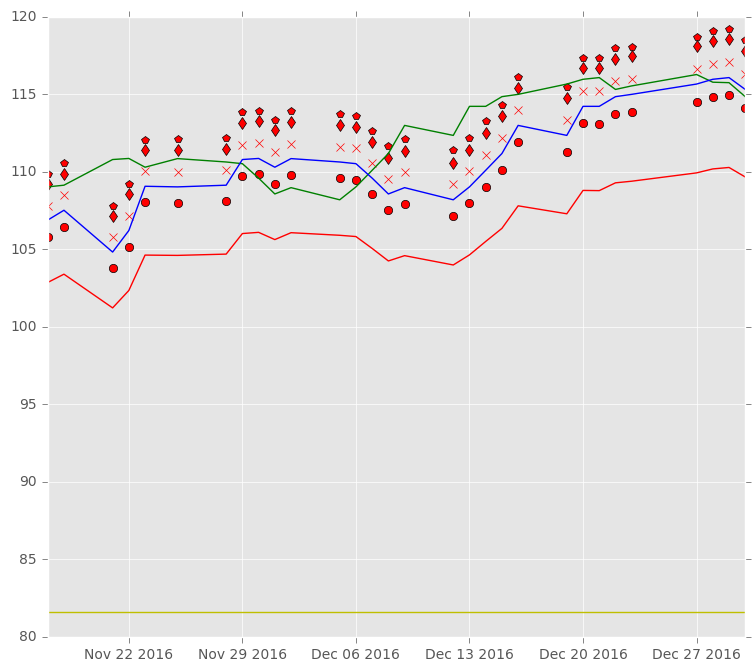

In [236]:
pyplot.figure(1,figsize=(9, 8))
pyplot.plot(compare.lasso_preds.tail(30),'rx')
pyplot.plot(compare.sgd_preds.tail(30),'rd')
pyplot.plot(compare.sgd2_preds.tail(30),'ro')
pyplot.plot(compare.sgd3_preds.tail(30),'rp')
pyplot.plot(compare.rfr_preds.tail(30),'y')
pyplot.plot(compare.average.tail(30),'r')
pyplot.plot(compare.true_future.tail(30),'g')
pyplot.plot(compare.current.tail(30),'b')
pyplot.show()

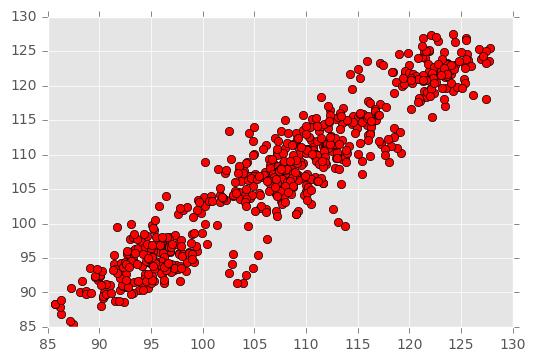

In [192]:
plt.plot(compare['lasso_preds'],compare['true_future'],'ro')

By Comparing the Graph above, and graph below, we see that our model is more correlated with the current price than with the future price that we are trying to predict

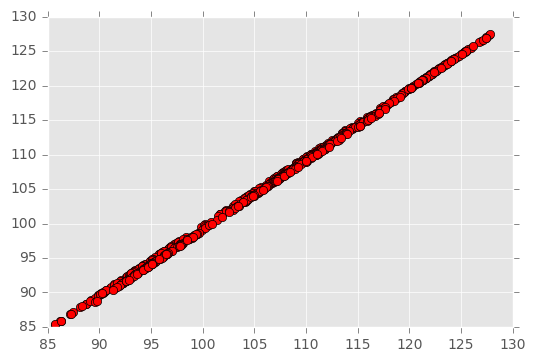

In [193]:
plt.plot(compare['lasso_preds'],compare['current'],'ro')

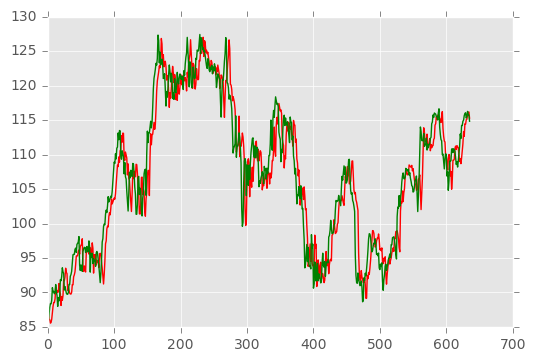

In [114]:
pyplot.plot(lasso_predictions,'r')
pyplot.plot(y_test.values,'g')
pyplot.show()

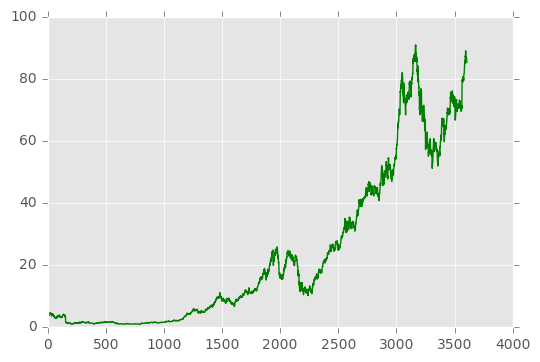

In [62]:
pyplot.plot(y_train.values,'g')
pyplot.show()

In [63]:
X_for_future_few = X_for_future[names]
future_lasso_predictions = lasso.predict(X_for_future_few)

In [64]:
future_lasso_predictions

array([ 115.78079474,  116.47228252,  115.97441006,  115.93541016,
        115.04971138])

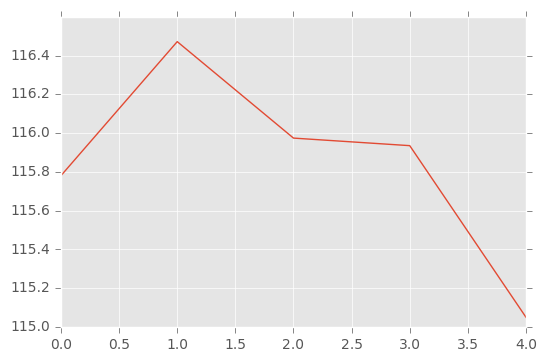

In [65]:
pyplot.plot(future_lasso_predictions)
pyplot.show()

## Feature Selection

I can use a DecisionTree to select the best variables

I can use a use a linear model to find the highest correlated variables

I also need to scale all the variables down to normalize them

I can add in calculated fields like:
    bolinger bands &
    Market Cap